# CSE 510 Reinforcement Learning Spring 2020 Assignment 2
# Value Function Approximation - Part TWO (CartPole)
## Srisai Karthik Neelamraju 50316785, neelamra@buffalo.edu

## Deep Q-learning for solving OpenAI CartPole

### Importing the required libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import random
from collections import deque
import time

### Defining the deep Q-learning agent class

In [0]:
class DQNAgent:
    def __init__(self, env, eps=1.0, eps_decay=0.99, eps_min=0.01, alpha=0.01, gamma=0.9, batch_size=32, MAX_EXP=10000):
        # initializing a deep Q-learning agent
        self.env = env
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_input = self.env.observation_space.shape[0]
        self.n_hidden = 10
        self.n_actions = self.env.action_space.n
        self.experiences = deque(maxlen=MAX_EXP)
        self.init_qnet()
        
    def init_qnet(self):
        self.qnet = tf.keras.Sequential()
        self.qnet.add(tf.keras.layers.Dense(self.n_hidden, input_shape = (self.n_input, ), activation='tanh'))
        self.qnet.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        optimizer = tf.keras.optimizers.Adam(lr=self.alpha)
        self.qnet.compile(loss="mean_squared_error", optimizer=optimizer)

    def store_experience(self, state, action, reward, next_state, done):
        self.experiences.append({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})

    def policy(self, state):
        # epsilon-greedy action selection
        self.eps = max([self.eps * self.eps_decay, self.eps_min])
        state = state.reshape(1, self.n_input)
        if np.random.uniform() < self.eps:
            return np.random.choice(self.n_actions)
        return np.argmax(self.predict_qvals(state))

    def predict_qvals(self, state):
        state = state.reshape(1, self.n_input)
        return self.qnet.predict(state)

    def train_qnet(self):
        # sampling a single experience for stochastic gradient descent
        batch = []
        batch.append(self.experiences[-1])

        # training the Q-network on these experiences
        states = []
        q_targets = []
        for exp in batch:
            state = exp['state']
            states.append(state)
            qval = exp['reward']
            if not exp['done']:
                qval += self.gamma * np.max(self.predict_qvals(exp['next_state']))
            q_target = self.predict_qvals(state)
            q_target[0][exp['action']] = qval
            q_targets.append(q_target.reshape(self.n_actions))
        self.qnet.fit(np.array(states), np.array(q_targets), verbose=False)

### Training the DQN agent on the OpenAI CartPole environment

In [0]:
# initializing the Cartpole-v0 environment
env_cp = gym.make("CartPole-v0")

# initializing the DQN agent
dqn_agent = DQNAgent(env_cp, alpha=0.01)

total_score = 0
avg_scores = []
last100_avg_scores = []
last100 = deque(maxlen=100)

episodes = 1000
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = dqn_agent.policy(state)
        next_state, reward, done, _ = env_cp.step(action)
        if done:
            reward = -reward
        dqn_agent.store_experience(state, action, reward, next_state, done)
        dqn_agent.train_qnet()
        np.copyto(state, next_state)
        score += 1
    total_score += score
    avg_scores.append(total_score/episode)
    last100.append(score)
    last100_avg_scores.append(np.mean(last100))
    print("Episode: " + str(episode) + ", Score: " + str(score) + ", Avg Score: " + str(avg_scores[-1]) + ", Avg Score (Last 100 runs): " + str(last100_avg_scores[-1]))

/projects/academic/doermann/fmonet/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 1, Score: 41, Avg Score: 41.0, Avg Score (Last 100 runs): 41.0
Episode: 2, Score: 13, Avg Score: 27.0, Avg Score (Last 100 runs): 27.0
Episode: 3, Score: 22, Avg Score: 25.333333333333332, Avg Score (Last 100 runs): 25.333333333333332
Episode: 4, Score: 9, Avg Score: 21.25, Avg Score (Last 100 runs): 21.25
Episode: 5, Score: 16, Avg Score: 20.2, Avg Score (Last 100 runs): 20.2
Episode: 6, Score: 12, Avg Score: 18.833333333333332, Avg Score (Last 100 runs): 18.833333333333332
Episode: 7, Score: 9, Avg Score: 17.428571428571427, Avg Score (Last 100 runs): 17.428571428571427
Episode: 8, Score: 11, Avg Score: 16.625, Avg Score (Last 100 runs): 16.625
Episode: 9, Score: 10, Avg Score: 15.88888888888889, Avg Score (Last 100 runs): 15.88888888888889
Episode: 10, Score: 17, Avg Score: 16.0, Avg Score (Last 100 runs): 16.0
Episode: 11, Score: 11, Avg Score: 15.545454545454545, Avg Score (Last 100 runs): 15.545454545454545
Episode: 12, Score: 10, Avg Score: 15.083333333333334, Avg Score

### Visualizing the average scores while training the DQN agent

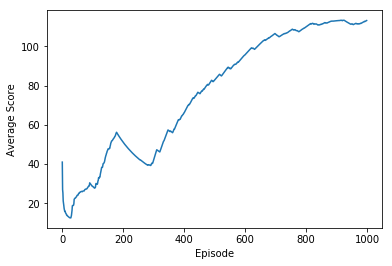

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.plot(avg_scores)

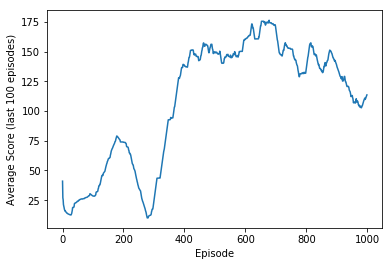

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score (last 100 episodes)')
plt.plot(last100_avg_scores)

### Observing performance of the trained DQN Agent for 100 episodes

In [0]:
# turning off the agent's exploration
dqn_agent.eps = 0
dqn_agent.eps_min = 0

test_last100 = []
test_last100_avg_scores = []

print("Testing the performance of the trained DQN Agent\n")

episodes = 100
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = dqn_agent.policy(state)
        next_state, _, done, _ = env_cp.step(action)
        np.copyto(state, next_state)
        score += 1
    test_last100.append(score)
    test_last100_avg_scores.append(np.mean(test_last100))
    print("Episode: " + str(episode) + ", Score: " + str(score))

print("Avg Score over 100 test episodes: " + str(np.mean(test_last100)))

Testing the performance of the trained DQN Agent

Episode: 1, Score: 200
Episode: 2, Score: 200
Episode: 3, Score: 200
Episode: 4, Score: 200
Episode: 5, Score: 200
Episode: 6, Score: 200
Episode: 7, Score: 200
Episode: 8, Score: 200
Episode: 9, Score: 200
Episode: 10, Score: 200
Episode: 11, Score: 200
Episode: 12, Score: 200
Episode: 13, Score: 200
Episode: 14, Score: 200
Episode: 15, Score: 200
Episode: 16, Score: 200
Episode: 17, Score: 200
Episode: 18, Score: 200
Episode: 19, Score: 200
Episode: 20, Score: 200
Episode: 21, Score: 200
Episode: 22, Score: 200
Episode: 23, Score: 200
Episode: 24, Score: 200
Episode: 25, Score: 200
Episode: 26, Score: 200
Episode: 27, Score: 200
Episode: 28, Score: 200
Episode: 29, Score: 200
Episode: 30, Score: 200
Episode: 31, Score: 200
Episode: 32, Score: 200
Episode: 33, Score: 200
Episode: 34, Score: 200
Episode: 35, Score: 200
Episode: 36, Score: 200
Episode: 37, Score: 200
Episode: 38, Score: 200
Episode: 39, Score: 200
Episode: 40, Score: 200

### Visualizing the average scores while testing the DQN agent

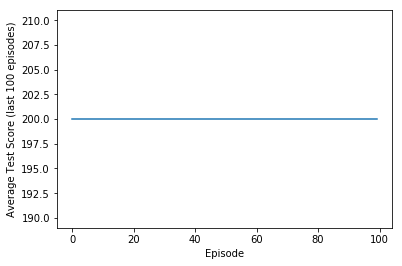

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Test Score (last 100 episodes)')
plt.plot(test_last100_avg_scores)

## Double Deep Q-learning for solving OpenAI CartPole

### Defining the double deep Q-learning agent class

In [0]:
class DDQNAgent:
    def __init__(self, env, eps=1.0, eps_decay=0.99, eps_min=0.01, alpha=0.01, gamma=0.9, batch_size=32, MAX_EXP=10000):
        # initializing a double deep Q-learning agent
        self.env = env
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_input = self.env.observation_space.shape[0]
        self.n_hidden = 10
        self.n_actions = self.env.action_space.n
        self.experiences = deque(maxlen=MAX_EXP)
        self.init_qnets()

    def init_qnets(self):
        # primary Q-network
        self.primary_qnet = tf.keras.Sequential()
        self.primary_qnet.add(tf.keras.layers.Dense(self.n_hidden, input_shape = (self.n_input, ), activation='tanh'))
        self.primary_qnet.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        optimizer = tf.keras.optimizers.Adam(lr=self.alpha)
        self.primary_qnet.compile(loss="mean_squared_error", optimizer=optimizer)

        # target Q-network
        self.target_qnet = tf.keras.Sequential()
        self.target_qnet.add(tf.keras.layers.Dense(self.n_hidden, input_shape = (self.n_input, ), activation='tanh'))
        self.target_qnet.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        self.target_qnet.set_weights(self.primary_qnet.get_weights())

    def store_experience(self, state, action, reward, next_state, done):
        self.experiences.append({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})

    def policy(self, state):
        # epsilon-greedy action selection
        self.eps = max([self.eps * self.eps_decay, self.eps_min])
        state = state.reshape(1, self.n_input)
        if np.random.uniform() < self.eps:
            return np.random.choice(self.n_actions)
        return np.argmax(self.primary_qvals(state))

    def primary_qvals(self, state):
        state = state.reshape(1, self.n_input)
        return self.primary_qnet.predict(state)

    def target_qvals(self, state):
        state = state.reshape(1, self.n_input)
        return self.target_qnet.predict(state)

    def train_qnet(self): 
        # sampling a single experience for stochastic gradient descent
        batch = []
        batch.append(self.experiences[-1])

        # training the primary Q-network
        states = []
        q_targets = []
        for exp in batch:
            state = exp['state']
            states.append(state)
            qval = exp['reward']
            if not exp['done']:
                qval += self.gamma * self.target_qvals(exp['next_state'])[0][np.argmax(self.primary_qvals(exp['next_state']))]
            q_target = self.primary_qvals(state)
            q_target[0][exp['action']] = qval
            q_targets.append(q_target.reshape(self.n_actions))
        self.primary_qnet.fit(np.array(states), np.array(q_targets), verbose=False)

### Training the DDQN agent on the OpenAI CartPole environment

In [0]:
# initializing the Cartpole-v0 environment
env_cp = gym.make("CartPole-v0")

# initializing the Double DQN agent
ddqn_agent = DDQNAgent(env_cp, alpha=0.01)

n_upd_target = 10
total_score = 0
avg_scores = []
last100_avg_scores = []
last100 = deque(maxlen=100)
count = 0

episodes = 1000
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = ddqn_agent.policy(state)
        next_state, reward, done, _ = env_cp.step(action)
        if done:
            reward = -reward
        ddqn_agent.store_experience(state, action, reward, next_state, done)
        ddqn_agent.train_qnet()
        np.copyto(state, next_state)
        score += 1
        count += 1
        if count % n_upd_target == 0:
            ddqn_agent.target_qnet.set_weights(ddqn_agent.primary_qnet.get_weights())
    total_score += score
    avg_scores.append(total_score/episode)
    last100.append(score)
    last100_avg_scores.append(np.mean(last100))
    print("Episode: " + str(episode) + ", Score: " + str(score) + ", Avg Score: " + str(avg_scores[-1]) + ", Avg Score (Last 100 runs): " + str(last100_avg_scores[-1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/projects/academic/doermann/fmonet/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 1, Score: 12, Avg Score: 12.0, Avg Score (Last 100 runs): 12.0
Episode: 2, Score: 20, Avg Score: 16.0, Avg Score (Last 100 runs): 16.0
Episode: 3, Score: 18, Avg Score: 16.666666666666668, Avg Score (Last 100 runs): 16.666666666666668
Episode: 4, Score: 12, Avg Score: 15.5, Avg Score (Last 100 runs): 15.5
Episode: 5, Score: 11, Avg Score: 14.6, Avg Score (Last 100 runs): 14.6
Episode: 6, Score: 10, Avg Score: 13.833333333333334, Avg Score (Last 100 runs): 13.833333333333334
Episode: 7, Score: 9, Avg Score: 13.142857142857142, Avg Score (Last 100 runs): 13.142857142857142
Episode: 8, Score: 19, Avg Score: 13.875, Avg Score (Last 100 runs): 13.875
Episode: 9, Score: 10, Avg Score: 13.444444444444445, Avg Score (Last 100 runs): 13.444444444444445
Episode: 10, Score: 10, Avg Score: 13.1, Avg Score (Last 100 runs): 13.1
Episode: 11, Score: 9, Avg Score: 12.727272727272727, Avg Score (Last 100 runs): 12.727272727272727
Episode: 12, Score: 10, Avg Score: 12.5, Avg Score (Last 100 run

### Visualizing the average scores while training the Double DQN agent

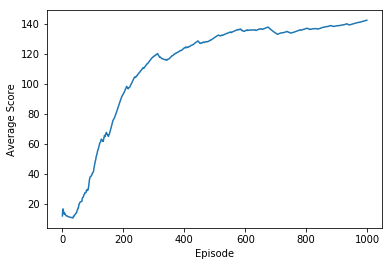

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.plot(avg_scores)

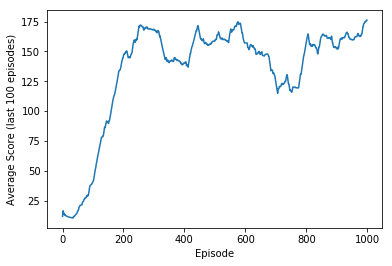

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score (last 100 episodes)')
plt.plot(last100_avg_scores)

### Observing performance of the trained Double DQN Agent for 100 episodes

In [0]:
# turning off the agent's exploration
ddqn_agent.eps = 0
ddqn_agent.eps_min = 0

test_last100 = []
test_last100_avg_scores = []

print("Testing the performance of the trained Double DQN Agent\n")

episodes = 100
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = dqn_agent.policy(state)
        next_state, _, done, _ = env_cp.step(action)
        np.copyto(state, next_state)
        score += 1
    test_last100.append(score)
    test_last100_avg_scores.append(np.mean(test_last100))
    print("Episode: " + str(episode) + ", Score: " + str(score))

print("Avg Score over 100 test episodes: " + str(np.mean(test_last100)))

Testing the performance of the trained Double DQN Agent

Episode: 1, Score: 200
Episode: 2, Score: 200
Episode: 3, Score: 200
Episode: 4, Score: 200
Episode: 5, Score: 200
Episode: 6, Score: 200
Episode: 7, Score: 200
Episode: 8, Score: 200
Episode: 9, Score: 200
Episode: 10, Score: 200
Episode: 11, Score: 200
Episode: 12, Score: 200
Episode: 13, Score: 200
Episode: 14, Score: 200
Episode: 15, Score: 200
Episode: 16, Score: 200
Episode: 17, Score: 200
Episode: 18, Score: 200
Episode: 19, Score: 200
Episode: 20, Score: 200
Episode: 21, Score: 200
Episode: 22, Score: 200
Episode: 23, Score: 200
Episode: 24, Score: 200
Episode: 25, Score: 200
Episode: 26, Score: 200
Episode: 27, Score: 200
Episode: 28, Score: 200
Episode: 29, Score: 200
Episode: 30, Score: 200
Episode: 31, Score: 200
Episode: 32, Score: 200
Episode: 33, Score: 200
Episode: 34, Score: 200
Episode: 35, Score: 200
Episode: 36, Score: 200
Episode: 37, Score: 200
Episode: 38, Score: 200
Episode: 39, Score: 200
Episode: 40, Sco

### Visualizing the average scores while testing the Double DQN agent

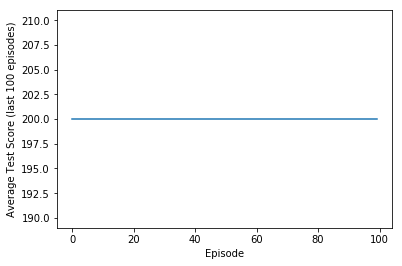

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Test Score (last 100 episodes)')
plt.plot(test_last100_avg_scores)